In [8]:
import pickle
import cv2
import numpy as np
with open('./data2.pickle','rb') as fr:
    data = pickle.load(fr)

In [ ]:
import imageio
import numpy as np
from math import sqrt
import sys
import argparse
import os


def get_fish_xn_yn(source_x, source_y, radius, distortion):
    """
    Get normalized x, y pixel coordinates from the original image and return normalized 
    x, y pixel coordinates in the destination fished image.
    :param distortion: Amount in which to move pixels from/to center.
    As distortion grows, pixels will be moved further from the center, and vice versa.
    """

    if 1 - distortion*(radius**2) == 0:
        return source_x, source_y

    return source_x / (1 - (distortion*(radius**2))), source_y / (1 - (distortion*(radius**2)))


def fish(img, distortion_coefficient):
    """
    :type img: numpy.ndarray
    :param distortion_coefficient: The amount of distortion to apply.
    :return: numpy.ndarray - the image with applied effect.
    """

    # If input image is only BW or RGB convert it to RGBA
    # So that output 'frame' can be transparent.
    w, h = img.shape[0], img.shape[1]
    if len(img.shape) == 2:
        # Duplicate the one BW channel twice to create Black and White
        # RGB image (For each pixel, the 3 channels have the same value)
        bw_channel = np.copy(img)
        img = np.dstack((img, bw_channel))
        img = np.dstack((img, bw_channel))
    if len(img.shape) == 3 and img.shape[2] == 3:
        print("RGB to RGBA")
        img = np.dstack((img, np.full((w, h), 255)))

    # prepare array for dst image
    dstimg = np.zeros_like(img)

    # floats for calcultions
    w, h = float(w), float(h)

    # easier calcultion if we traverse x, y in dst image
    for x in range(len(dstimg)):
        for y in range(len(dstimg[x])):

            # normalize x and y to be in interval of [-1, 1]
            xnd, ynd = float((2*x - w)/w), float((2*y - h)/h)

            # get xn and yn distance from normalized center
            rd = sqrt(xnd**2 + ynd**2)

            # new normalized pixel coordinates
            xdu, ydu = get_fish_xn_yn(xnd, ynd, rd, distortion_coefficient)

            # convert the normalized distorted xdn and ydn back to image pixels
            xu, yu = int(((xdu + 1)*w)/2), int(((ydu + 1)*h)/2)

            # if new pixel is in bounds copy from source pixel to destination pixel
            if 0 <= xu and xu < img.shape[0] and 0 <= yu and yu < img.shape[1]:
                dstimg[x][y] = img[xu][yu]

    return dstimg.astype(np.uint8)


def parse_args(args=sys.argv[1:]):
    """Parse arguments."""

    parser = argparse.ArgumentParser(
        description="Apply fish-eye effect to images.",
        prog='python3 fish.py')

    parser.add_argument("-i", "--image", help="path to image file."
                        " If no input is given, the supplied example 'grid.jpg' will be used.",
                        type=str, default="grid.jpg")

    parser.add_argument("-o", "--outpath", help="file path to write output to."
                        " format: <path>.<format(jpg,png,etc..)>",
                        type=str, default="fish.png")

    parser.add_argument("-d", "--distortion",
                        help="The distoration coefficient. How much the move pixels from/to the center."
                        " Recommended values are between -1 and 1."
                        " The bigger the distortion, the further pixels will be moved outwars from the center (fisheye)."
                        " The Smaller the distortion, the closer pixels will be move inwards toward the center (rectilinear)."
                        " For example, to reverse the fisheye effect with --distoration 0.5,"
                        " You can run with --distortion -0.3."
                        " Note that due to double processing the result will be somewhat distorted.",
                        type=float, default=0.5)

    return parser.parse_args(args)


if __name__ == "__main__":
    args = parse_args()
    try:
        imgobj = imageio.imread(args.image)
    except Exception as e:
        print(e)
        sys.exit(1)
    if os.path.exists(args.outpath):
        ans = input(
            args.outpath + " exists. File will be overridden. Continue? y/n: ")
        if ans.lower() != 'y':
            print("exiting")
            sys.exit(0)
    
    output_img = fish(imgobj, args.distortion)
    imageio.imwrite(args.outpath, output_img, format='png')


In [9]:
def distortion_img(img):
    img =cv2.remap(img,data['map_x'],data['map_y'],interpolation=cv2.INTER_NEAREST)
    return img
def distortion_mask(img):
    img[img==255]=12
    img  +=1
    img =cv2.remap(img,data['map_x'],data['map_y'],interpolation=cv2.INTER_NEAREST)
    return img

[  0   2   4   5   6   7   8  11 255]
[  0   2   4   5   6   7   8  11 255]
[ 0  1  3  5  6  7  8  9 12 13]


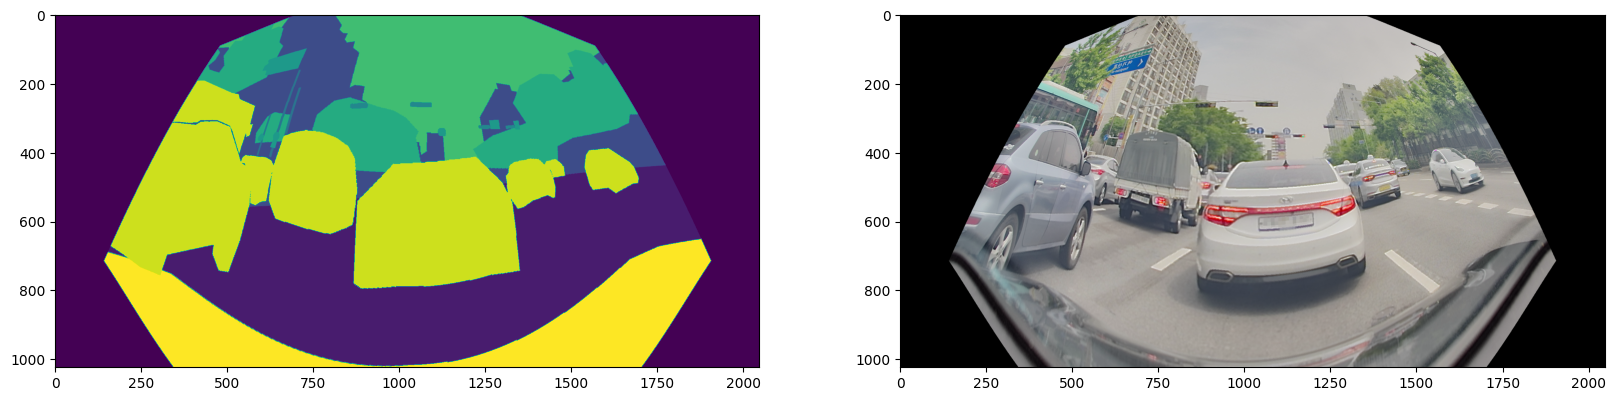

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.core.transforms_interface import ImageOnlyTransform,DualTransform
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

class BarrelDistortion(DualTransform):

    def __init__(
        self,
        always_apply=False,
        p=1
 ):

        super(BarrelDistortion, self).__init__(always_apply, p)

    def apply(self, img, **params):
        return distortion_mask(img)

image = cv2.imread('./train_source_image/TRAIN_SOURCE_0011.png')
ori_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ori_mask = cv2.imread('./train_source_gt/TRAIN_SOURCE_0011.png', cv2.IMREAD_GRAYSCALE)
transform = A.Compose([
    # A.OpticalDistortion(distort_limit=0.8,shift_limit=1,p=1),
#    A.fourier_domain_adaptation(img = image,target_img = target_imaeg, beta =0.3),
    BarrelDistortion(),
    # A.Resize(width=512, height=256),
    # A.RandomCrop(width=224,height=224,p=0.3)
    # A.Normalize(mean=ADE_MEAN, std=ADE_STD)
])
print(np.unique(ori_mask))
print(np.unique(ori_mask))
augmented = transform(image=ori_image, mask=ori_mask)
# ori_mask[ori_mask == 255] = 30
print(np.unique(augmented['mask']))
plt.figure(figsize=(20,30))
plt.subplot(1,2,1)
plt.imshow(augmented['mask'])
plt.subplot(1,2,2)
plt.imshow(augmented['image'])
# [ 0  1  2  3  6  7  8 11 12] 기존 ->  0  1  2  3  4  5  6  7  8  9 10 11 12

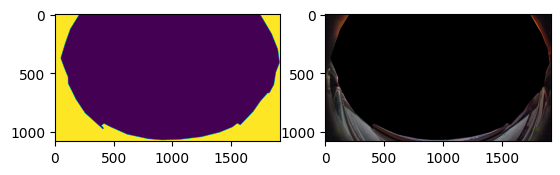

In [12]:
mask = cv2.imread('./mask.png',cv2.IMREAD_GRAYSCALE)
# mask[mask==0]=255
image = cv2.imread('./source.jpg')
plt.subplot(1,2,1)
plt.imshow(mask)
plt.subplot(1,2,2)
test1 = cv2.copyTo(image,mask)
plt.imshow(test1)

# ori_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

1023 717 811


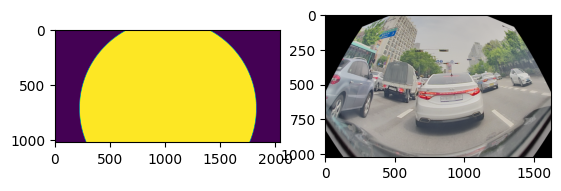

In [13]:
from scipy.optimize import leastsq
import numpy as np
import cv2
import matplotlib.pyplot as plt

# image = augmented['image'].permute(1,2,0).numpy()
# Function to calculate the residuals for least squares circle fit
def calculate_residuals(c, x, y):
    xi = c[0]
    yi = c[1]
    ri = c[2]
    return ((x-xi)**2 + (y-yi)**2 - ri**2)
def make_mask_circle(image):
    # Initialize lists to store the coordinates of the first non-black pixels from left and right for each row
    x_coords = []
    y_coords = []

    non_vignetting_threshold = 20
    inner_circle_margin = 10
    # image_path = "./train_target_image/TRAIN_TARGET_0000.png"
    # img = cv2.imread("./train_target_image/TRAIN_TARGET_0000.png")
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Scan each row of the image
    for i in range(img_gray.shape[0]):

        # Scan from the left
        for j in range(img_gray.shape[1]):
            if np.any(img_gray[i,j] > non_vignetting_threshold):
                x_coords.append(j)
                y_coords.append(i)
                break

        # Scan from the right
        for j in range(img_gray.shape[1]-1, -1, -1):
            if np.any(img_gray[i,j] > non_vignetting_threshold):
                x_coords.append(j)
                y_coords.append(i)
                break

    # Convert the lists to numpy arrays
    x = np.array(x_coords)
    y = np.array(y_coords)

    # Initial guess for circle parameters (center at middle of image, radius half the image width)
    c0 = [img_gray.shape[1]/2, img_gray.shape[0]/2, img_gray.shape[1]/4]

    # Perform least squares circle fit
    c, _ = leastsq(calculate_residuals, c0, args=(x, y))

    img_color = image.copy()
    # Draw the circle on the original image
    cv2.circle(img_color, (int(c[0]), int(c[1])), int(c[2])-10, (0, 255, 0), 2);

    # Fill in the inside of the circle
    mask_valid = np.zeros((image.shape[0], image.shape[1])).astype(np.uint8)
    image2 = cv2.circle(mask_valid, (int(c[0]), int(c[1])), int(c[2])-inner_circle_margin, 1, -1);
    # image2 = image2[int(c[0])-int(c[2]):int(c[0])+int(c[2]),int(c[1])-int(c[2]):int(c[1])+int(c[2])]
    return image2,int(c[0]),int(c[1]),int(c[2])
mask_valid ,c0,c1,c2= make_mask_circle(augmented['image'])
print(c0,c1,c2)
plt.subplot(1,2,1)
plt.imshow(mask_valid)
plt.subplot(1,2,2)
# plt.imshow(augmented['image'][c1-c2:c1+c2,c0-c2:c0+c2])
y_bot = c1 -c2 if c1-c2 >0 else 0
y_top = c1+c2 if mask_valid.shape[1]<c1+c2 else mask_valid.shape[1]
x_bot = c0-c2 
x_top = c0+c2
plt.imshow(augmented['image'][y_bot:y_top,x_bot:x_top])

(824, 1482) (824, 1482)
[ 0  1  3  5  6  7  8  9 12 13]
[ 0  1  3  5  6  7  8  9 12 13]


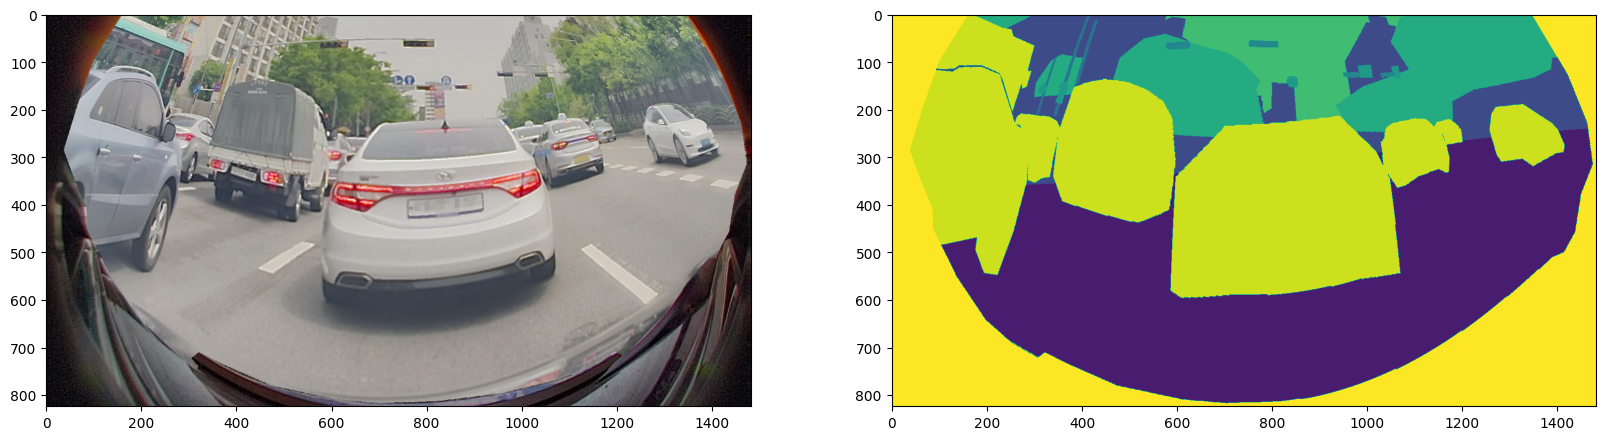

In [14]:
# mask_valid = make_mask_circle(image)
y_maring = 200
x_marging =70
y_bot = c1 -c2 if c1-c2 >0 else 0
y_top = c1+c2 if mask_valid.shape[1]<c1+c2 else mask_valid.shape[1]
x_bot = c0-c2 
x_top = c0+c2
# test = cv2.copyTo(augmented['image'],mask_valid)[y_bot+y_maring:y_top-y_maring,x_bot+x_marging:x_top-x_marging]
# test2 = cv2.copyTo(augmented['mask'],mask_valid)[y_bot+y_maring:y_top-y_maring,x_bot+x_marging:x_top-x_marging]
test = augmented['image'][y_bot+y_maring:y_top-y_maring,x_bot+x_marging:x_top-x_marging]
test2 = augmented['mask'][y_bot+y_maring:y_top-y_maring,x_bot+x_marging:x_top-x_marging]

h,w = test.shape[:2]
mask = cv2.imread('./mask.png',cv2.IMREAD_GRAYSCALE)
# cv2.resize(mask,dsize=(h,w))
# mask[mask==0]=255
image = cv2.imread('./source.jpg')
mask = cv2.resize(mask,dsize=(w,h))
# mask[mask==1
image = cv2.resize(image,dsize=(w,h))
print(test2.shape,mask.shape)
test2[mask==1]=13

print(np.unique(test2))
test = cv2.copyTo(image,mask,test)
# test2 = cv2.copyTo(mask,mask,test2)
print(np.unique(test2))
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(test)
plt.subplot(1,2,2)
# test2[test2==13]=13
plt.imshow(test2)

In [6]:
from glob import glob
t = glob("./train_source_image/*.png")
t[0].split('/')

['.', 'train_source_image', 'TRAIN_SOURCE_1692.png']

In [7]:
from glob import glob
from tqdm.auto import tqdm
train_valid = 'val' # val
train_source_path=  glob(f'./{train_valid}_source_image/*.png')
train_mask_path = glob(f'./{train_valid}_source_gt/*.png')
mask_target = cv2.imread('./mask.png',cv2.IMREAD_GRAYSCALE)
# cv2.resize(mask,dsize=(h,w))
# mask[mask==0]=255
image_target = cv2.imread('./source.jpg')
mask_target = cv2.resize(mask_target,dsize=(w,h))
# mask[mask==1
image_target = cv2.resize(image_target,dsize=(w,h))
# print(train_mask_path[0].split("\\")[-1])
import os
os.makedirs(f'./{train_valid}_fishimage',exist_ok=True)
os.makedirs(f'./{train_valid}_maskimg',exist_ok=True)
for i in tqdm(range(len(train_source_path))):
    source = cv2.imread(train_source_path[i], cv2.COLOR_BGR2RGB)
    mask = cv2.imread(train_mask_path[i], cv2.COLOR_BGR2GRAY)
    mask = distortion_mask(mask)
    source = distortion_img(source)
    mask_valid,c0,c1,c2 = make_mask_circle(source)
    y_bot = c1 -c2 if c1-c2 >0 else 0
    y_top = c1+c2 if mask_valid.shape[1]<c1+c2 else mask_valid.shape[1]
    x_bot = c0-c2 
    x_top = c0+c2
    # source2fish = cv2.copyTo(source,mask_valid)[y_bot+y_maring:y_top-y_maring,x_bot+x_marging:x_top-x_marging]
    # mask2fish = cv2.copyTo(mask,mask_valid)[y_bot+y_maring:y_top-y_maring,x_bot+x_marging:x_top-x_marging]
    source2fish = source[y_bot+y_maring:y_top-y_maring,x_bot+x_marging:x_top-x_marging]
    mask2fish = mask[y_bot+y_maring:y_top-y_maring,x_bot+x_marging:x_top-x_marging]
    h,w = source2fish.shape[:2]
    mask_target = cv2.resize(mask_target,dsize=(w,h))
# mask[mask==1
    image_target = cv2.resize(image_target,dsize=(w,h))
    mask2fish[mask_target==1]=13
    source2fish = cv2.copyTo(image_target,mask_target,source2fish)
    image_name = train_source_path[i].split('/')[-1]
    mask_name = train_mask_path[i].split('/')[-1]
    print(image_name,mask_name)
    cv2.imwrite((f'./{train_valid}_fishimage/'+image_name),source2fish)
    # path = './val_source_image2fish/'+image_name
    # print(path)
    cv2.imwrite((f'./{train_valid}_maskimg/'+mask_name),mask2fish)


NameError: name 'cv2' is not defined

# Make CSV

In [16]:
from glob import glob
import pandas as pd
data = []
train_source_path=  glob('./val_source_image/*.png')
train_mask_path = glob('./val_source_gt/*.png')
train_valid = 'train'
for img,mask in zip(train_source_path,train_mask_path):
    id = img.split('\\')[-1].split('.')[0]
    img_path = f'./{train_valid}_fishimg/'
    mask_path= f'./{train_valid}_maskimg/'
    data.append([id,img_path+id+'.png',mask_path+id+'.png'])
new_df = pd.DataFrame(data,columns=['id','img_path','gt_path'])
new_df.to_csv('val_source_fish.csv',index=False)

ModuleNotFoundError: No module named 'pandas'

In [ ]:
import pandas as pd
data = []
train_source_path=  glob('./train_source_image/*.png')
train_mask_path = glob('./train_source_gt/*.png')

for img,mask in zip(train_source_path,train_mask_path):
    id = img.split('\\')[-1].split('.')[0]
    img_path = './train_fish_img/'
    mask_path= './train_mask_img/'
    data.append([id,img_path+id+'.png',mask_path+id+'.png'])
new_df = pd.DataFrame(data,columns=['id','img_path','gt_path'])
new_df.to_csv('train_source_fish.csv',index=False)